In [22]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

Öncelikle, iki boş liste oluşturdum: biri etiketler için (label), diğeri ise dosya yolları için (path). Ardından, os.walk() fonksiyonunu kullanarak belirttiğim dizindeki (balık görüntülerinin bulunduğu klasör) alt dizinleri ve dosyaları gezdim.

Her bir dosya adını kontrol ederken, dosyanın uzantısının .png olup olmadığını kontrol ettim. Eğer dosya uzantısı bu şekildeyse ve dizin adı 'GT' değilse, dizin adından balık türünü çıkardım ve bunu etiket listesine ekledim. Aynı zamanda, dosya yolunu da path listesine ekledim.

Sonrasında, bu iki listeyi kullanarak bir pandas veri çerçevesi oluşturdum. Bu çerçeve, her bir görüntü için dosya yolunu ve etiketini tutuyor. Son olarak, veri çerçevesinin ilk birkaç satırını görmek için data.head() fonksiyonunu kullandım ve genel bilgileri incelemek için data.info() komutunu çalıştırdım. Böylece, balık görüntülerinin etiketleri ve yollarını içeren düzenli bir yapı oluşturmuş oldum. 

In [23]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label


data.head()


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


Öncelikle, idx değişkenini sıfır olarak tanımladım ve ardından 15x12 boyutunda bir figür oluşturdum.

Daha sonra, veri çerçevesindeki her bir benzersiz etiketi (unique_label) döngü ile gezdim. Her etiket için bir alt grafikte (subplot) görüntüyü göstermek üzere ayarlamalar yaptım. Eğer mevcut etiket için görüntü varsa, label_data adlı bir veri çerçevesi oluşturup ilk satırdan dosya yolunu aldım. Bu dosyayı okuyarak görüntüyü (img) yüklüyorum ve imshow ile gösteriyorum. Ayrıca, alt grafik başlığı olarak balık türünü yazıyorum.

Eğer o etiket için herhangi bir görüntü yoksa, "No Image" yazısını merkezde göstererek bu durumu belirtiyorum ve başlığı da buna göre güncelliyorum. Her alt grafikte eksenleri kapatmayı da unutmuyorum.

Son olarak, tüm bu alt grafiklerin bulunduğu figürü plt.show() ile ekranda görüntülüyorum. Böylece, veri setindeki her balık türü için örnek görüntüleri görsel olarak sunmuş oluyorum. Bu, hangi türlerin bulunduğunu ve her birinin görsel temsilini hızlıca incelememi sağlıyor.

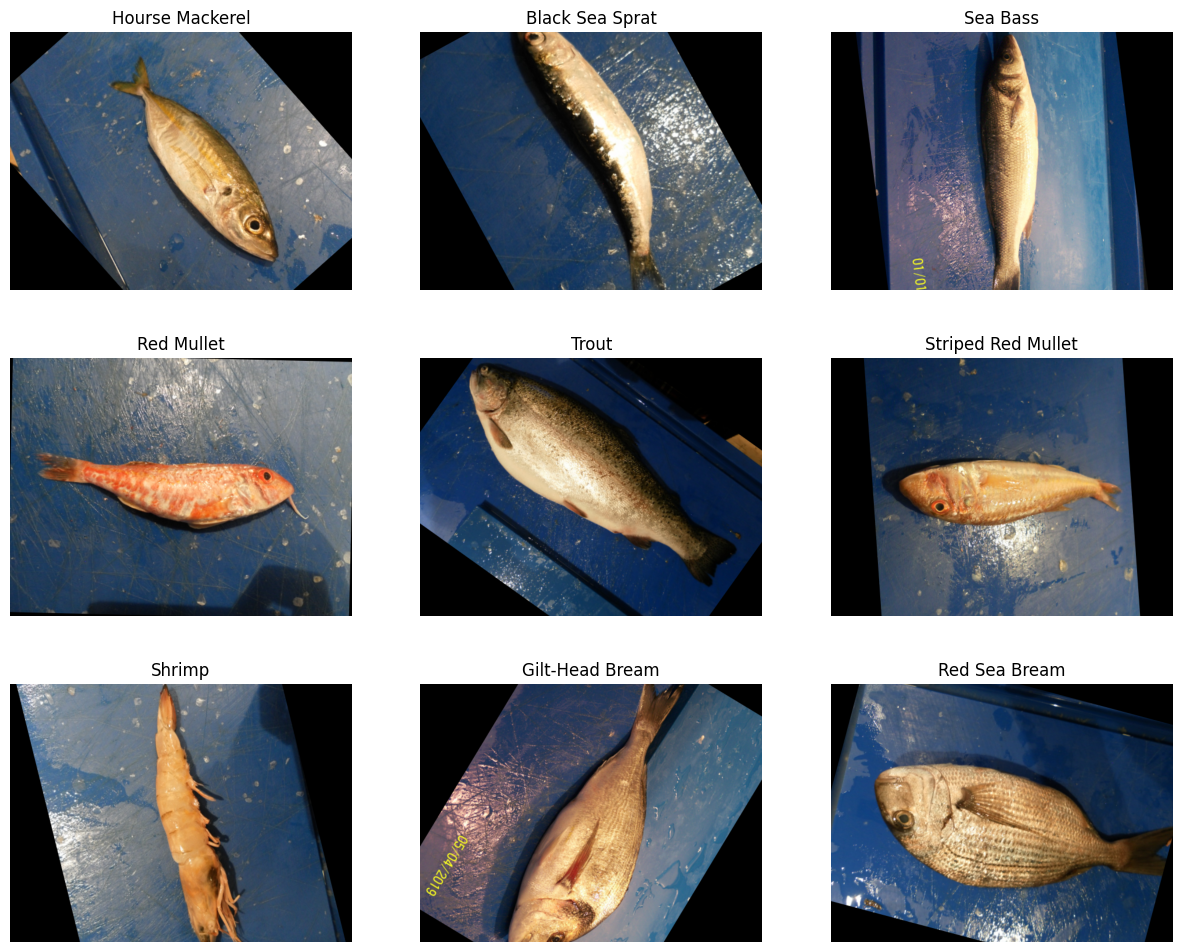

In [24]:
idx = 0 
plt.figure(figsize=(15,12))

for unique_label in data['label'].unique():
    plt.subplot(3, 3, idx+1)
    
    label_data = data[data['label'] == unique_label]
    
    if not label_data.empty:
        img_path = label_data.iloc[0, 0]
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(unique_label)
    else:
        plt.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12)
        plt.title(unique_label + ' (No Image)')
    
    plt.axis('off')
    idx += 1

plt.show()

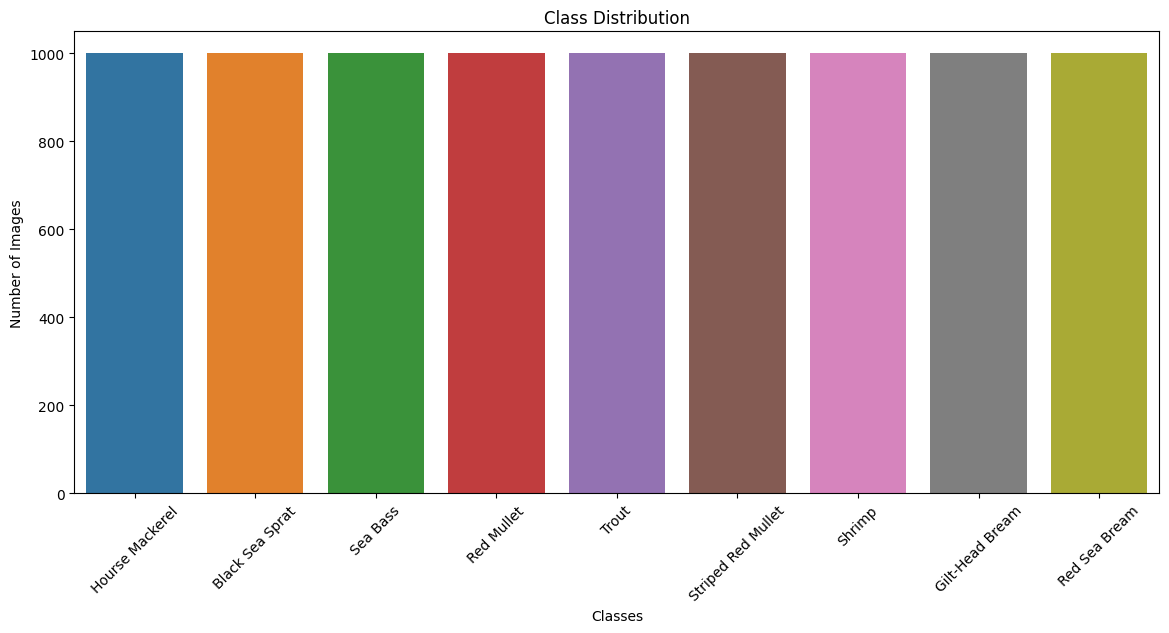

In [25]:

plt.figure(figsize=(14, 6))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  
plt.show()

Öncelikle, train_test_split fonksiyonu ile veri çerçevesini eğitim ve test setlerine ayırdım. Burada test setinin boyutunu %20 olarak belirledim ve verilerin karışmasını sağlamak için shuffle=True kullandım. Ayrıca, sonuçların tutarlılığı için random_state=42 ayarladım.

Sonrasında, eğitim seti için veri artırma işlemi gerçekleştirmek üzere ImageDataGenerator sınıfını kullandım. rescale=1./255 ile görüntü değerlerini [0, 1] aralığına ölçekledim. Eğitim setinin %20'sini doğrulama seti olarak ayırmak için validation_split=0.2 ekledim.

Benzer şekilde, doğrulama seti için de bir ImageDataGenerator oluşturdum, aynı ölçeklendirme ve doğrulama ayarlarını burada da kullandım. Test seti içinse sadece rescale işlemi uyguladım; burada doğrulama veya eğitimle ilgili bir ayar yapmadım.

Sonrasında, flow_from_dataframe fonksiyonu ile eğitim, doğrulama ve test görüntülerini yüklüyorum. Her bir ImageDataGenerator nesnesi ile ilgili veri çerçevesinden dosya yollarını (x_col='path') ve etiketleri (y_col='label') kullanarak görüntüleri yükledim. target_size=(28, 28) ile görüntü boyutunu 28x28 piksele ayarladım. Renk modunu RGB olarak belirledim ve etiketleme için class_mode='categorical' kullandım. Her bir gruptaki görüntü sayısını batch_size=64 olarak ayarladım.

Eğitim ve doğrulama veri setleri için verilerin karışmasını sağlamak amacıyla shuffle=True kullandım, ancak test setinde bu işlemi uygulamadım (shuffle=False).

Sonuç olarak, bu kod ile modelimi eğitmek için gerekli veri setlerini hazırlamış oldum.

In [26]:
# Splitting the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

# Data Augmentation for the training set
train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,    
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2    
)

test_generator = ImageDataGenerator(rescale=1./255)

# Loading the images using flow_from_dataframe
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


Öncelikle, TensorFlow'un Keras API'sinden regularizers modülünü içe aktarıyorum. Bu modül, modelin aşırı öğrenmesini (overfitting) önlemek için düzenleme (regularization) yöntemlerini kullanmamı sağlıyor.

Modeli tanımlamak için Sequential() sınıfını kullanarak bir model oluşturuyorum.

Katmanlar:
Giriş Katmanı: Flatten katmanı ile 28x28 piksel boyutundaki RGB görüntülerini tek boyutlu bir diziye çeviriyorum. Bu, modelin giriş şekli olarak belirtiyorum.

Gizli Katmanlar:

İlk gizli katmanda, 1024 nöron içeren bir Dense katmanı ekliyorum ve ReLU aktivasyon fonksiyonu kullanıyorum. Ayrıca, kernel_regularizer=regularizers.l2(0.001) ile L2 düzenlemesi ekleyerek aşırı öğrenmeyi önlemeye çalışıyorum.
Ardından, BatchNormalization katmanı ile öğrenme sürecini hızlandırmayı ve modelin kararlılığını artırmayı hedefliyorum.
Dropout(0.2) katmanı ile de her eğitim aşamasında nöronların %20'sini rastgele devre dışı bırakarak modelin genel performansını artırmaya çalışıyorum.
Bu sırayla, 512, 256, 128 ve 64 nöronlu başka Dense katmanları ekliyorum. Her birinde ReLU aktivasyonı, L2 düzenlemesi ve gerektiğinde Dropout katmanı kullanarak aşırı öğrenme riskini azaltmaya odaklanıyorum.
Çıkış Katmanı: Son olarak, Dense katmanını 9 nöronla ekliyorum; bu, 9 balık türünü temsil ediyor. softmax aktivasyon fonksiyonunu kullanarak her sınıfın olasılıklarını elde ediyorum.

Modelin yapısını görmek için model.summary() ile modelin katmanları, nöron sayıları ve parametre sayıları hakkında bilgi alıyorum. Böylece, modelin genel mimarisini ve karmaşıklığını değerlendiriyorum

In [27]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential()

# Input Layer
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# Hidden Layers
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))

# Output Layer
model.add(tf.keras.layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,113,481 (11.88 MB)

 Trainable params: 3,110,409 (11.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

Early Stopping
Öncelikle, EarlyStopping geri çağrısını (callback) tanımlıyorum. Bu, doğrulama kaybını (val_loss) izleyerek modelin aşırı öğrenmesini önlemeye yardımcı oluyor.

patience=5 parametresi ile, eğer modelin doğrulama kaybı 5 epoch boyunca iyileşmezse, eğitim durdurulacak.
restore_best_weights=True ile de en iyi ağırlıkların geri yüklenmesini sağlıyorum, böylece en iyi performansı gösteren modelin ağırlıkları ile sonuç almış oluyorum.


Öğrenme Oranı Planlayıcısı (Learning Rate Scheduler)
lr_scheduler adında bir fonksiyon tanımlıyorum. Bu fonksiyon, eğitim süresince öğrenme oranını güncelleyerek ayarlıyor.

Eğer epoch sayısı 20 veya daha fazla ise, mevcut öğrenme oranını 0.990 ile çarpıyorum. Bu, modelin daha stabil bir şekilde öğrenmesini sağlamak için yararlı oluyor. Epoch sayısı arttıkça overfit oranı da artıyor bunu önlemek ve yerel minimumları daha iyi yakalayabilmek için öğrenme oranını düşürmek iyi olabilir.
Sonrasında, LearningRateScheduler geri çağrısını oluşturarak bu fonksiyonu çağırıyorum.

Modeli Derleme
Modeli derlemek için model.compile() fonksiyonunu kullanıyorum:

Optimizer: Adagrad optimizasyon algoritmasını kullanarak başlangıç öğrenme oranını 0.01 olarak ayarlıyorum.
NOT : Farklı optimizasyon algoritmalarından en iyi sonuç aldığım bu idi.
Kayıp Fonksiyonu: Çok sınıflı sınıflandırma problemleri için uygun olan categorical_crossentropy kayıp fonksiyonunu seçiyorum.
Metrikler: Modelin başarımını değerlendirmek için accuracy, precision, recall ve F1Score metriklerini kullanıyorum. 

Modeli Eğitme
Son olarak, model.fit() fonksiyonu ile modeli eğitiyorum:

Eğitim verilerini (train_images), toplam epoch sayısını (100), batch boyutunu (64) ve doğrulama verilerini (val_images) belirtiyorum.
Ayrıca, daha önce tanımladığım early_stopping ve lr_scheduler_callback geri çağrılarını kullanarak eğitim sürecini optimize ediyorum.

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall', 'F1Score'],              
)

# Training the model
results = model.fit(
    train_images, 
    epochs=100, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping,lr_scheduler_callback]
)

Epoch 1/100


I0000 00:00:1729713015.653832     427 service.cc:145] XLA service 0x7c3bd4007d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729713015.653912     427 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/90 ━━━━━━━━━━━━━━━━━━━━ 24:45 17s/step - F1Score: 0.1169 - accuracy: 0.1250 - loss: 5.1442 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1729713021.243805     427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - F1Score: 0.3007 - accuracy: 0.3099 - loss: 4.5840 - precision: 0.6223 - recall: 0.0919 - val_F1Score: 0.2725 - val_accuracy: 0.2764 - val_loss: 4.5660 - val_precision: 0.5093 - val_recall: 0.0951 - learning_rate: 0.0100
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 683ms/step - F1Score: 0.6289 - accuracy: 0.6377 - loss: 3.7204 - precision: 0.7824 - recall: 0.4494 - val_F1Score: 0.6208 - val_accuracy: 0.6299 - val_loss: 3.8683 - val_precision: 0.7746 - val_recall: 0.2625 - learning_rate: 0.0100
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 684ms/step - F1Score: 0.7585 - accuracy: 0.7604 - loss: 3.3834 - precision: 0.8441 - recall: 0.6550 - val_F1Score: 0.7965 - val_accuracy: 0.8035 - val_loss: 3.3205 - val_precision: 0.9152 - val_recall: 0.6444 - learning_rate: 0.0100
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 683ms/step - F1Score: 0.8263 - accuracy: 0.8281 - loss: 3.1370 - precision: 0.8815 - recall: 0.7592 - val_F1Score: 0.8317 - val_accuracy: 0.832

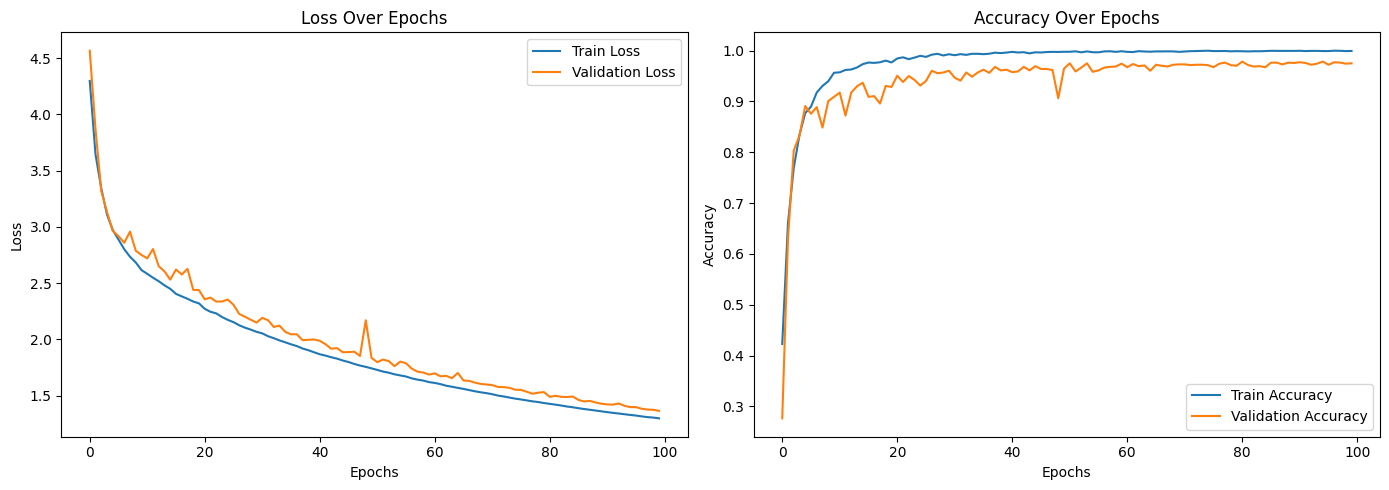

In [29]:
plt.figure(figsize=(14, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 575ms/step


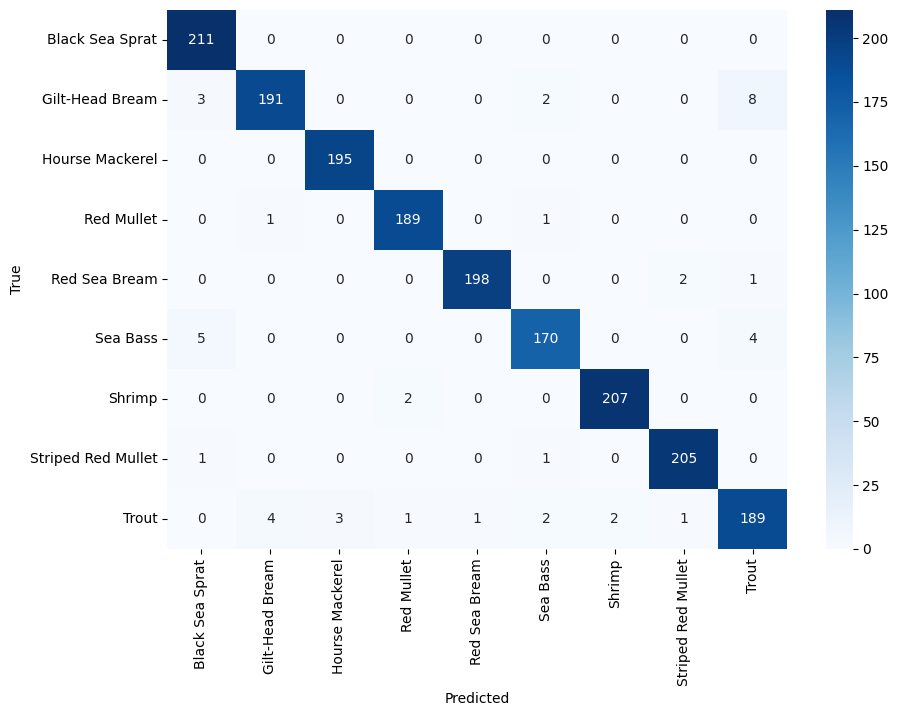

                    precision    recall  f1-score   support

   Black Sea Sprat       0.96      1.00      0.98       211
   Gilt-Head Bream       0.97      0.94      0.96       204
   Hourse Mackerel       0.98      1.00      0.99       195
        Red Mullet       0.98      0.99      0.99       191
     Red Sea Bream       0.99      0.99      0.99       201
          Sea Bass       0.97      0.95      0.96       179
            Shrimp       0.99      0.99      0.99       209
Striped Red Mullet       0.99      0.99      0.99       207
             Trout       0.94      0.93      0.93       203

          accuracy                           0.97      1800
         macro avg       0.98      0.97      0.97      1800
      weighted avg       0.98      0.97      0.97      1800



In [33]:



# Step 1: Predict the labels for the test set
# Since the output of the model is probabilities, we use `argmax` to get the predicted class
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the test_images generator
y_true = test_images.classes

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 3: Generate the classification report
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))


In [35]:
for i in range(10):
    print(f"True label: {y_true[i]}, Predicted label: {y_pred[i]}")


True label: 1, Predicted label: 1
True label: 0, Predicted label: 0
True label: 2, Predicted label: 2
True label: 8, Predicted label: 8
True label: 4, Predicted label: 4
True label: 4, Predicted label: 4
True label: 7, Predicted label: 7
True label: 4, Predicted label: 4
True label: 3, Predicted label: 3
True label: 8, Predicted label: 8


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 581ms/step


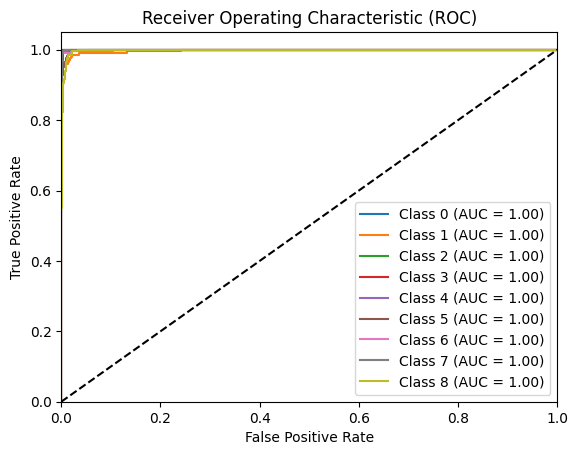

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC calculation
y_true_bin = label_binarize(y_true, classes=np.arange(9))  # Assuming 9 classes
y_pred_prob = model.predict(test_images)  # Predicted probabilities

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(9):  # Adjust this to the number of classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure()
for i in range(9):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [38]:
from collections import Counter

# Convert y_true and y_pred to numpy arrays if they are not already
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Initialize a dictionary to store the accuracies for each class
class_accuracies = {}

# Loop through each unique class in y_true
for class_label in np.unique(y_true):
    # Find the indices where the class label matches
    class_idx = np.where(y_true == class_label)[0]
    
    # Calculate the number of correct predictions for the current class
    correct = np.sum(y_true[class_idx] == y_pred[class_idx])
    
    # Store the accuracy for the current class
    class_accuracies[class_label] = correct / len(class_idx)

# Print the accuracy for each class
for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for class {class_label}: {accuracy:.2f}')



Accuracy for class 0: 1.00
Accuracy for class 1: 0.94
Accuracy for class 2: 1.00
Accuracy for class 3: 0.99
Accuracy for class 4: 0.99
Accuracy for class 5: 0.95
Accuracy for class 6: 0.99
Accuracy for class 7: 0.99
Accuracy for class 8: 0.93


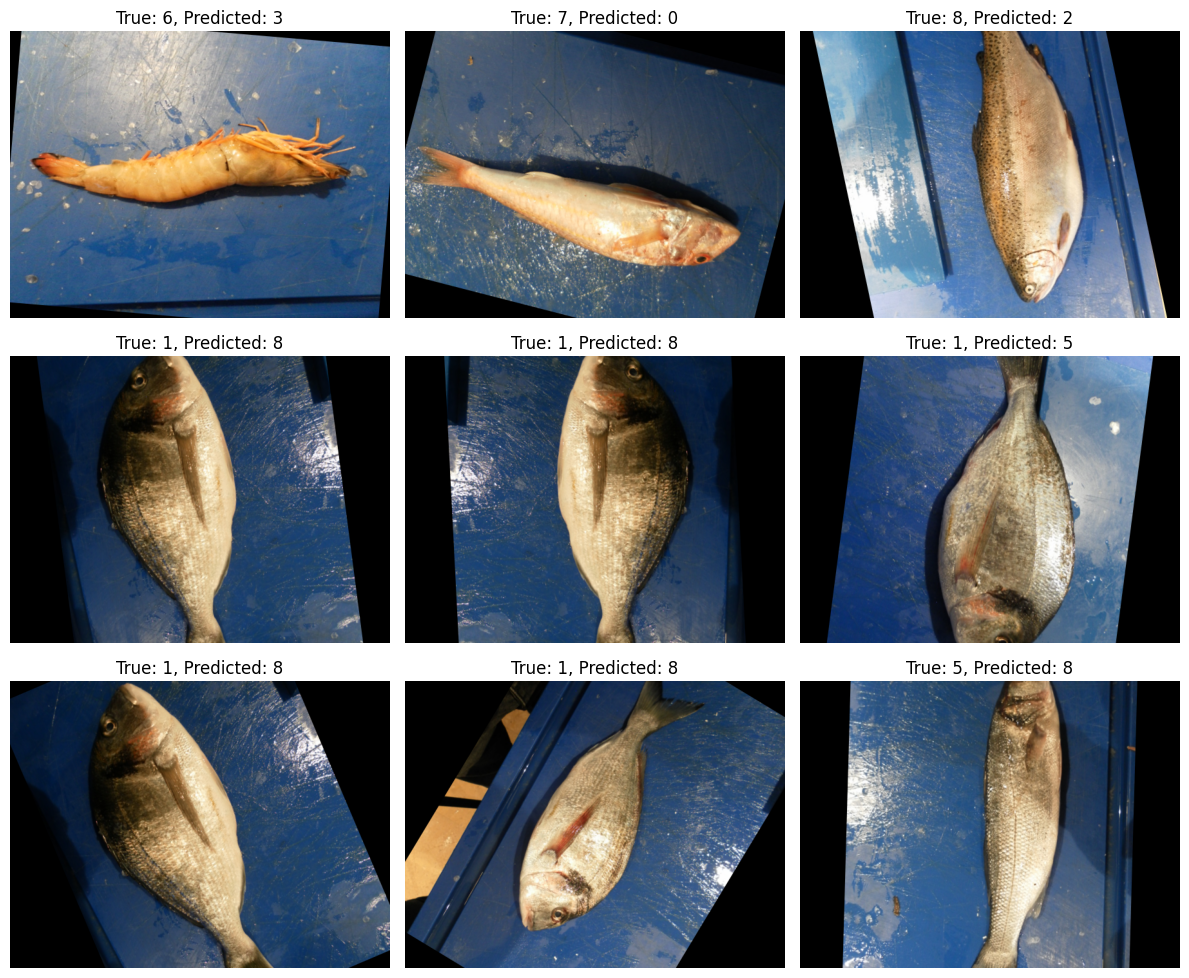

In [39]:
misclassified_idx = np.where(y_true != y_pred)[0]

plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idx[:9]):  # Show first 9 misclassified examples
    plt.subplot(3, 3, i+1)
    img_path = test_images.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"True: {y_true[idx]}, Predicted: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


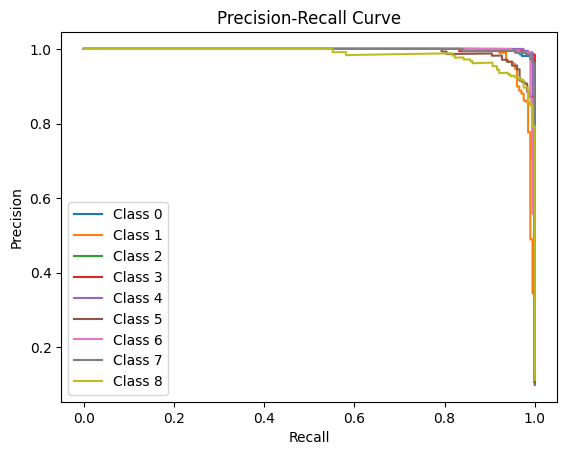

In [40]:
from sklearn.metrics import precision_recall_curve

precision = {}
recall = {}
for i in range(9):  # Assuming 9 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])

# Plotting the precision-recall curves
plt.figure()
for i in range(9):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
